In [3]:
import heapq #heap[0] is the root, after all kd-tree is a heap binary tree
import itertools
import operator #perform mathematical operations for objects and all kinds of data
import math
from collections import deque #specialised container datatypes
#Deques are a generalization of stacks and queues
#the name is short for “double-ended queue”. 
#Deques support thread-safe, memory efficient appends and pops from either side of the deque with 
#approximately the same O(1) performance in either direction.
from functools import wraps #any callable object can be treated as a function 
import pandas as pd #data analysis and manipulation tool
from shapely.geometry import Point #manipulation and analysis of planar geometric objects
import matplotlib.pyplot as plt
import timeit #measuring execution times



class Node(object):

    def __init__(self, data=None, left=None, right=None): #node init, empty at the beginning
        self.data = data
        self.left = left
        self.right = right


    @property
    def is_leaf(self): #Returns True if a Node is a leaf(0 subnodes)
        return (not self.data) or \
               (all(not bool(c) for c, p in self.children))

    def iterate(self): #iterators for root,left,right
        
        if not self:
            return

        if self.left:
            for x in self.left.iterate():
                yield x # yield instead of return, to enable function to resume where it is left off

        
        yield self


        if self.right:
            for x in self.right.iterate():
                yield x
        
        
        

    
    @property
    def children(self): #Returns an iterator for the non-empty children of the Node
        #The children are returned as (Node, position) tuples where position is 0 for the
        #left subnode and 1 for the right.

        if self.left and self.left.data is not None:
            yield self.left, 0
        if self.right and self.right.data is not None:
            yield self.right, 1


    def set_child(self, index, child): #Sets one of the node's children. index 0 refers to the left, 1 to the right child

        if index == 0:
            self.left = child
        else:
            self.right = child


    def height(self): #Returns height of the (sub)tree, without considering empty leaf-nodes

        min_height = int(bool(self))
        return max([min_height] + [c.height()+1 for c, p in self.children]) #min-height is converted to list


    def get_child_pos(self, child): #Returns the position of the given child.
        #If the given node is the left child, 0 is returned. If it's the right child, 1 is returned.

        for c, pos in self.children:
            if child == c:
                return pos


    def __repr__(self): #data representation for node and data. Also for debugging reasons
        #using cls instead of self, because we need to access a class attribute, not an instance one
        return '<%(cls)s - %(data)s>' % \
            dict(cls=self.__class__.__name__, data=repr(self.data))


    def __nonzero__(self):
        return self.data is not None

    __bool__ = __nonzero__

    #maybe we dont need the eq method (???)
    def __eq__(self, other):#for point equilibrium. Python is kinda "dumb" on this
        if isinstance(other, tuple): #checks whether an object is an instance of a class or of a subclass
            #tuples are not mutable!
            return self.data == other
        else:
            return self.data == other.data

    def __hash__(self): #make object hashable, since we implemented the __eq__
        return id(self) 



    def require_axis(f):#check if object has axis 

        @wraps(f)
        def _wrapper(self, *args, **kwargs): #for debugging reasons
            if None in (self.axis, self.sel_axis):
                raise ValueError('%(func_name) requires the node %(node)s '
                        'to have an axis and a sel_axis function' %
                        dict(func_name=f.__name__, node=repr(self)))

            return f(self, *args, **kwargs)

        return _wrapper

          


class KDNode(Node):
    """ Creates a new node for a kd-tree
        If the node will be used within a tree, the axis and the sel_axis
        function should be supplied.
        sel_axis(axis) is used when creating subnodes of the current node. It
        receives the axis of the parent node and returns the axis of the child
        node. """

    def __init__(self, data=None, left=None, right=None, axis=None,
            sel_axis=None, dimensions=None):
        super(KDNode, self).__init__(data, left, right)#calls a constructor of the superclass
        self.axis = axis
        self.sel_axis = sel_axis
        self.dimensions = dimensions


    def require_axis(f):#check if object has axis 

        @wraps(f)
        def _wrapper(self, *args, **kwargs): #for debugging reasons
            if None in (self.axis, self.sel_axis):
                raise ValueError('%(func_name) requires the node %(node)s '
                        'to have an axis and a sel_axis function' %
                        dict(func_name=f.__name__, node=repr(self)))

            return f(self, *args, **kwargs)

        return _wrapper


    @require_axis
    def add(self, point): #Adds a point to the current node or iteratively descends to one of its children.

        current = self
        while True:
            check_dimensionality([point], dimensions=current.dimensions)#check if given dimensions is valid

            if current.data is None: #empty leaf-node case
                current.data = point
                return current

            #split and recurse left
            if point[current.axis] < current.data[current.axis]:
                if current.left is None:
                    current.left = current.create_subnode(point)
                    return current.left
                else:
                    current = current.left
            else:#split and recurse right
                if current.right is None:
                    current.right = current.create_subnode(point)
                    return current.right
                else:
                    current = current.right
        
        if not current.is_balanced: #after the adds, check balace and rebalace if needed
            current.rebalance()
        

    @require_axis
    def create_subnode(self, data):#creates subnode for current node 

        return self.__class__(data,
                axis=self.sel_axis(self.axis),
                sel_axis=self.sel_axis,
                dimensions=self.dimensions)


    @require_axis
    def find_replacement(self): #finds replacement for the current node
        if self.right:
            child, parent = self.right.extreme_child(min, self.axis)
        else:
            child, parent = self.left.extreme_child(max, self.axis)

        return (child, parent if parent is not None else self)


    def should_remove(self, point, node):#check if point matches. Mostly for testing and debugging reasons
        if not self.data == point:
            return False

        return (node is None) or (node is self)


    @require_axis
    def remove(self, point, node=None):
        """ Checks for the removal candidate.
        If there are multiple points matching point(parameter), only one is removed. The
        optional "node" parameter is used for checking the identity, once the
        removal candidate is decided."""


        # Recursion has reached an empty leaf node, nothing here to delete
        if not self:
            return

        # Recursion has reached the node to be deleted
        if self.should_remove(point, node):
            return self._remove(point)

        # Remove direct subnode
        if self.left and self.left.should_remove(point, node):
            self.left = self.left._remove(point)

        elif self.right and self.right.should_remove(point, node):
            self.right = self.right._remove(point)

        
        # Recurse to subtrees
        if point[self.axis] <= self.data[self.axis]:
            if self.left:
                self.left = self.left.remove(point, node)

        if point[self.axis] >= self.data[self.axis]:
            if self.right:
                self.right = self.right.remove(point, node)

        #if not self.is_balanced: #after the adds, check balace and rebalace if needed
           # self.rebalance()
        return self


    @require_axis
    def _remove(self, point): #this is actually the function that deletes the node
        if self.is_leaf:#leaf deletion, nothing special
            self.data = None
            return self

        # non-leaf deletion, a bit more complicated
        # first, we need to find a replacement for the node (will be the new subtree-root)
        root, max_p = self.find_replacement()
        # self and root swap positions
        tmp_l, tmp_r = self.left, self.right
        self.left, self.right = root.left, root.right
        root.left, root.right = tmp_l if tmp_l is not root else self, tmp_r if tmp_r is not root else self
        self.axis, root.axis = root.axis, self.axis

         #very special-case if we have not chosen a direct child as the replacement
        if max_p is not self:
            pos = max_p.get_child_pos(root)
            max_p.set_child(pos, self)
            max_p.remove(point, self)

        else:
            root.remove(point, self)

        return root


    @property
    def is_balanced(self): #check if (sub)tree is balanced(boolean result). 
        #balanced =  the heights of both sub-trees differ by 1 at most
        

        left_height = self.left.height() if self.left else 0
        right_height = self.right.height() if self.right else 0

        if abs(left_height - right_height) > 1:
            return False

        return all(c.is_balanced for c, _ in self.children)


    def rebalance(self): #Returns the new root of the rebalanced tree after the iteration

        return create([x.data for x in self.iterate()])


    def axis_dist(self, point, axis):
        """
        Squared distance(for the actual distance we need to root that(maybe not needed????))
         AT THE GIVEN AXIS between the current Node and the given point
        """
        return math.pow(self.data[axis] - point[axis], 2)


    def dist(self, point):
        #Squared distance between the current Node and the given point. NOT AXIS DISTANCE
        r = range(self.dimensions)
        return sum([self.axis_dist(point, i) for i in r])


    def search_knn(self, point, k, dist=None):
        """ Return the k nearest neighbors of point and their distances
        point must be an actual point, not a node.
        k is the number of results to return. The actual results can be less
        (if there aren't more nodes to return) or more in case of equal
        distances.
        dist is a distance function, expecting two points and returning a
        distance value. Distance values can be any comparable type.
        The result is an ordered list of (node, distance) tuples.
        """

        if k < 1:
            raise ValueError("k must be greater than 0.") #In case someone search for 0 nearest neightbors 

        if dist is None:
            get_dist = lambda n: n.dist(point) #using lambda because point is "anonymous"
        else:
            get_dist = lambda n: dist(n.data, point)

        results = []

        self._search_node(point, k, results, get_dist, itertools.count())

        # We sort the final result by the distance in the tuple  (<KdNode>, distance).

        return [(node, -d) for d, _, node in sorted(results, reverse=True)] # sorted in descending order



    def _search_node(self, point, k, results, get_dist, counter):
        if not self:
            return

        nodeDist = get_dist(self)
        # Add current node to the priority queue if it closer than at least one point in the queue.
        # If the heap is at its capacity, we need to check if the
        # current node is closer than the current farthest node, and if so, replace it.
        item = (-nodeDist, next(counter), self)
        if len(results) >= k:
            if -nodeDist > results[0][0]:
                heapq.heapreplace(results, item) #Pop and return the current smallest value, and add the new item
        else:
            heapq.heappush(results, item) #Push item onto heap, maintaining the heap invariant.
        # get the splitting plane
        split_plane = self.data[self.axis]
        # get the squared distance between the point and the splitting plane
        plane_dist = point[self.axis] - split_plane
        plane_dist2 = plane_dist * plane_dist
        # Search the side of the splitting plane that the point is in
        if point[self.axis] < split_plane:
            if self.left is not None:
                self.left._search_node(point, k, results, get_dist, counter)
        else:
            if self.right is not None:
                self.right._search_node(point, k, results, get_dist, counter)
        # Search the other side of the splitting plane if it may contain
        # points closer than the farthest point in the current results.
        if -plane_dist2 > results[0][0] or len(results) < k:
            if point[self.axis] < self.data[self.axis]:
                if self.right is not None:
                    self.right._search_node(point, k, results, get_dist, counter)
            else:
                if self.left is not None:
                    self.left._search_node(point, k, results, get_dist, counter)


    def extreme_child(self, sel_func, axis):
        """ Returns a child of the subtree and its parent
        The child is selected by sel_func which is either min or max """

        max_key = lambda child_parent: child_parent[0].data[axis]

        # we don't know our parent, so we include None
        me = [(self, None)] if self else []

        child_max = [c.extreme_child(sel_func, axis) for c, _ in self.children]
        # insert self for unknown parents
        child_max = [(c, p if p is not None else self) for c, p in child_max]

        candidates =  me + child_max

        if not candidates:
            return None, None

        return sel_func(candidates, key=max_key)


    def search_point(self, point, node=None, flag=0):
        
        current = self
        if current.data == point:
            flag = -1
            print('Tree parsed. Point identified.')
            return self

        if point[current.axis] <= current.data[current.axis]:
            if current.left:
                current.left = current.left.search_point(point, node,flag)
                flag = 0
            else:
                flag = flag + 1

        if point[current.axis] >= current.data[self.axis]:
            if current.right:
                current.right = current.right.search_point(point, node,flag)
                flag = 0
            else:
                flag = flag + 1

        if(flag > 0):
            print('Error! Point is not in dataset')

        return self

    @require_axis
    def range_search(self, point, distance, best=None):
        results = []
        get_dist = lambda n: n.dist(point)

        self._range_search(point, distance, results, get_dist)
        return results
    
    def _range_search(self, point, dist, results, get_dist):
        if not self:
            return

        nodeDist = get_dist(self)

        if nodeDist < dist:
            results.append(self.data)

        split_plane = self.data[self.axis]

        if point[self.axis] <= split_plane + dist:
            if self.left is not None:
                self.left._range_search(point, dist, results, get_dist)
        if point[self.axis] >= split_plane - dist:
            if self.right is not None:
                self.right._range_search(point, dist, results, get_dist)
        
    def update(self, point, new_point):
        
        current = self
        
        current.remove((point))
        
        current.add((new_point))
        
        current.rebalance()
        
        return current


def create(point_list=None, dimensions=None, axis=0, sel_axis=None):

    """ Creates a kd-tree from a list of points
    All points in the list must be of the same dimensionality.
    If no point_list is given, an empty tree is created. The number of
    dimensions has to be given instead.
    If both a point_list and dimensions are given, the numbers must agree.
    Axis is the axis on which the root-node should split.
    sel_axis(axis) is used when creating subnodes of a node. It receives the
    axis of the parent node and returns the axis of the child node. """

    if not point_list and not dimensions:
        raise ValueError('Either point_list or dimensions must be provided')
    elif point_list:
        dimensions = check_dimensionality(point_list, dimensions)

    # by default cycle through the axis
    sel_axis = sel_axis or (lambda prev_axis: (prev_axis+1) % dimensions)

    if not point_list:
        return KDNode(sel_axis=sel_axis, axis=axis, dimensions=dimensions)

    # Sort point list and choose median as pivot element
    point_list = list(point_list)
    point_list.sort(key=lambda point: point[axis])
    median = len(point_list) // 2

    loc   = point_list[median]
    left  = create(point_list[:median], dimensions, sel_axis(axis))
    right = create(point_list[median + 1:], dimensions, sel_axis(axis))
    return KDNode(loc, left, right, axis=axis, sel_axis=sel_axis, dimensions=dimensions) #create and construct sub-trees


def check_dimensionality(point_list, dimensions=None):
    dimensions = dimensions or len(point_list[0])
    for p in point_list:
        if len(p) != dimensions:
            raise ValueError('All Points in the point_list must have the same dimensionality')

    return dimensions



def plot_tree(tree, min_x, max_x, min_y, max_y, prev_node, branch, depth=0):
 
    line_width = [4., 3., 2., 1., .5, 0.3] #for visualization purposes
    cur_node = tree.data      #current tre node  
    left_branch = tree.left    #it's left branch
    right_branch = tree.right  #it's right branch


    if depth > len(line_width)-1: #set plane's line width based on the depth
            ln_width = line_width[len(line_width)-1]
    else:
            ln_width = line_width[depth]
   
    k = len(cur_node)
    axis = depth % k
 
 
    if axis == 0: #vertical split
 
        if branch is not None and prev_node is not None: #branch param: T if left, F if right
 
            if branch:
                max_y = prev_node[1]
            else:
                min_y = prev_node[1]
 
        plt.plot([cur_node[0],cur_node[0]], [min_y,max_y], linestyle='-', color='green', linewidth=ln_width) #draws the split lane (vertical)
 
 
    elif axis == 1: #horizontal split
 
        if branch is not None and prev_node is not None:
 
            if branch:
                max_x = prev_node[0]
            else:
                min_x = prev_node[0]
 
        plt.plot([min_x,max_x], [cur_node[1],cur_node[1]], linestyle='-', color='blue', linewidth=ln_width) #draws the split lane(horizonal)
 
 
    plt.plot(cur_node[0], cur_node[1], marker='o', color='red') # draw the current node(as a dot)
 
    #recursive procedure for left and right branches
    if left_branch is not None:
        if left_branch.data is not None:
            plot_tree(left_branch, min_x, max_x, min_y, max_y, cur_node, True, depth+1)
    if right_branch is not None:
        if right_branch.data is not None:
            plot_tree(right_branch, min_x, max_x, min_y, max_y, cur_node, False, depth+1)    
    
    
df = pd.read_csv("airports.csv", delimiter=',', skiprows=0, low_memory=False) #read the dataset
df2 = pd.read_csv("airports3.csv", delimiter=',', skiprows=0, low_memory=False) 
l = len(df)
l2 = len(df2)

list_time = timeit.default_timer()
point_list = [((df['lat'][j], df['lng'][j]))
           for j in range(l)]

point_list2 = [((df2['lat'][j], df2['lng'][j]))
           for j in range(l2)]

start_time = timeit.default_timer()

tree = create(point_list, 2) #create the KD tree(K=2)

print("Tree created in %s seconds. " % (timeit.default_timer() - start_time))

tree2 = create(point_list2, 2)
#coord values
min_val = -180  
max_val = 180  
delta = 150


plt.show()
plt.close()



Tree created in 0.13813699999991513 seconds. 


--- Point addition time: 0.0001280999999977439 seconds ---


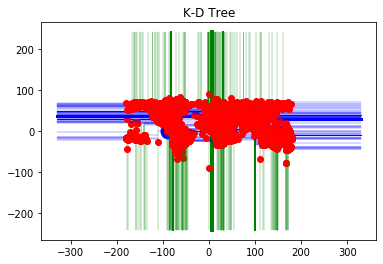

In [2]:
import timeit

point_addition = timeit.default_timer()
tree.add((-88.164854397615025,0.124379655037946 ))
print("--- Point addition time: %s seconds ---" % (timeit.default_timer() - point_addition))
plt.plot([-88.164854397615025],[0.124379655037946], marker='o', color='blue', markersize=15)

# draw the tree
plot_tree(tree, min_val-delta, max_val+delta, -90-delta, 90+delta, None, None)

plt.title('K-D Tree')
plt.show()
plt.close()

--- Point deletion time: 0.00020900000004075991 seconds ---


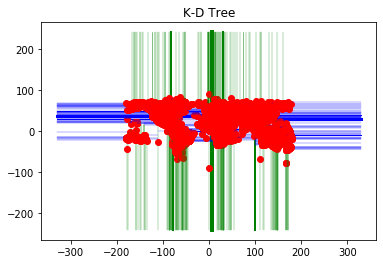

In [3]:
point_deletion = timeit.default_timer()
tree.remove((-88.164854397615025,0.124379655037946 )) 
print("--- Point deletion time: %s seconds ---" % (timeit.default_timer() - point_deletion))
# draw the tree
plot_tree(tree, min_val-delta, max_val+delta, -90-delta, 90+delta, None, None)

plt.title('K-D Tree')
plt.show()
plt.close()

--- K-nn search time: 0.005847800000083225 seconds ---
Result:  [(<KDNode - (53.9640998840332, 22.51449966430664)>, 5.446268044543103), (<KDNode - (50.83689880371094, 18.71929931640625)>, 6.85303446483158), (<KDNode - (52.463600158691406, 24.07399940490723)>, 10.042633247478102), (<KDNode - (52.61399841308594, 24.18740081787109)>, 10.854175186555926), (<KDNode - (52.580278, 24.283610999999997)>, 11.471714413871824), (<KDNode - (54.02460098266602, 17.666000366210938)>, 13.613904227531773), (<KDNode - (52.55989837646485, 24.780500411987305)>, 15.05795113722343), (<KDNode - (53.07714080810547, 24.862491607666016)>, 16.26818935619667), (<KDNode - (54.5476989746, 24.248199462900004)>, 16.33164706311605), (<KDNode - (54.45809936523438, 24.428300857543945)>, 17.165750027346835), (<KDNode - (54.651100158691406, 24.433000564575195)>, 18.08127032954144), (<KDNode - (52.87369918823242, 25.14620018005371)>, 18.303191016562778), (<KDNode - (54.09130096435547, 17.038700103759766)>, 18.31729973340407

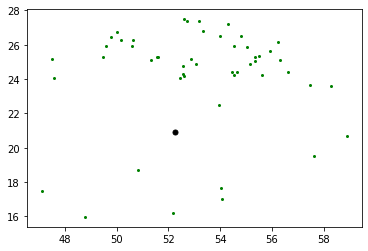

In [4]:
knn_search = timeit.default_timer()
result_node = tree.search_knn((52.26850128173828,20.910999298095703),50)
print("--- K-nn search time: %s seconds ---" % (timeit.default_timer() - knn_search))
print("Result: "  , result_node)

i = 0
while i < len(result_node):
    plt.plot([result_node[i][0].data[0]],[result_node[i][0].data[1]],marker='o', color='green', markersize=2) 
    i = i +1
plt.plot([52.26850128173828],[20.910999298095703],marker='o', color='black', markersize=5)

In [5]:
import timeit 

point_search = timeit.default_timer()
tree.search_point((-43.16583251953125,-22.95166778564453))
print("--- Point search time: %s seconds ---" % (timeit.default_timer() - point_search))

Tree parsed. Point identified.
--- Point search time: 0.003802199999995537 seconds ---


In [6]:
point_search = timeit.default_timer()
tree.search_point((-111.148634970054849, 18.157603133951479))
print("--- Point search time: %s seconds ---" % (timeit.default_timer() - point_search))

Error! Point is not in dataset
--- Point search time: 0.00201860000004217 seconds ---


--- Point update time: 1.55523380000011 seconds ---


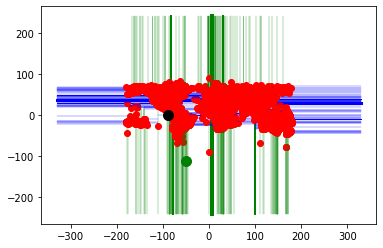

In [7]:
point_update = timeit.default_timer()
tree.update((-88.164854397615025,0.124379655037946),(-50.123456778101112,-112.112233445566778)) 
print("--- Point update time: %s seconds ---" % (timeit.default_timer() - point_update))

#draw the tree
plot_tree(tree, min_val-delta, max_val+delta, -90-delta, 90+delta, None, None)
plt.plot([-88.164854397615025],[0.124379655037946], marker='o', color='black', markersize=10) #the deleted one
plt.plot([-50.123456778101112],[-112.112233445566778], marker='o', color='green', markersize=10) #the added one

--- Point range query time: 0.06918140000016137 seconds ---


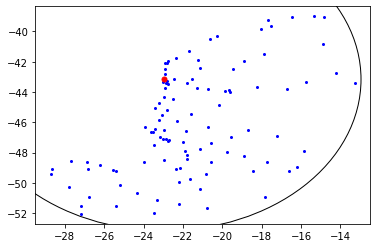

In [5]:
import timeit
range_time = timeit.default_timer()
result = tree2.range_search((-22.95166778564453,-43.16583251953125),100)
print("--- Point range query time: %s seconds ---" % (timeit.default_timer() - range_time))
for i in range(len(result)):
    plt.plot([result[i][0]],[result[i][1]], marker='o', color='blue', markersize=2)
plt.plot([-22.95166778564453],[-43.16583251953125], marker='o', color='red', markersize=5)
circle2 = plt.Circle((-22.95166778564453,-43.16583251953125), 10, color='black', fill=False)
plt.gcf().gca().add_artist(circle2)


In [9]:
import sys

def get_size(obj, seen=None):
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()   #create empty set
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

size = get_size(tree)
print('Size of kd-tree: ',size,' bytes.')

Size of kd-tree:  9977729  bytes.
